In [29]:
import time

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_absolute_percentage_error
from matplotlib import pyplot as plt
from torchinfo import summary
from ptflops import get_model_complexity_info

seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [30]:

class StandardLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StandardLSTM, self).__init__()
        self.hidden_size = hidden_size

        # Defining the first LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)

        # Defining the second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)

        # Fully connected layer that outputs the predicted value
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initial hidden and cell states are zero
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # First LSTM layer
        out, (hn, cn) = self.lstm1(x, (h0, c0))

        # Second LSTM layer
        out, (hn, cn) = self.lstm2(out, (hn, cn))

        # Reshape the output from the second LSTM layer to fit the fully connected layer
        out = out[:, -1, :]  # Taking the last time step's output

        # Fully connected layer
        out = self.fc(out)
        return out

In [31]:
def load_and_preprocess_data():
    df = pd.read_csv('data/jena_climate.csv')
    scaler = StandardScaler()
    dataset = scaler.fit_transform(df[['Tpot (K)', 'wd (deg)', 'VPact (mbar)', 'sh (g/kg)',
                                       'H2OC (mmol/mol)', 'rho (g/m**3)', 'p (mbar)']].values)
    return dataset

In [32]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1][0][0]  # predict the next value
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [33]:
# Parameters
input_size = 7
hidden_size = 128
output_size = 1

timesteps = 1
batch_size = 16
epochs = 50

In [34]:
# Load data
data = load_and_preprocess_data()
train_size = int(len(data) * 0.8)

train_data = data[:train_size]
test_data = data[train_size:]

# Create sequences
train_sequences = create_inout_sequences(train_data, timesteps)
test_sequences = create_inout_sequences(test_data, timesteps)

# Dataloaders
train_dataset = TensorDataset(torch.tensor([i[0] for i in train_sequences], dtype=torch.float32), torch.tensor([i[1] for i in train_sequences], dtype=torch.float32))
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = TensorDataset(torch.tensor([i[0] for i in test_sequences], dtype=torch.float32), torch.tensor([i[1] for i in test_sequences], dtype=torch.float32))
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [35]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StandardLSTM(input_size, hidden_size, output_size).to(device)
print(summary(model))

Layer (type:depth-idx)                   Param #
StandardLSTM                             --
├─LSTM: 1-1                              70,144
├─LSTM: 1-2                              132,096
├─Linear: 1-3                            129
Total params: 202,369
Trainable params: 202,369
Non-trainable params: 0


In [36]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = [] # Initialize lists to record losses
test_losses = []  # Initialize lists to record test losses
start_time=time.time()#record time

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Record average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Evaluate on test set
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y.unsqueeze(1))
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch + 1}, Train Loss: {avg_loss}, Test Loss: {avg_test_loss}")


end_time = time.time()
print("Total Train program time:%f" % (end_time - start_time))  #Total Train program time:51.145797

print(summary(model))
torch.save(model,'modelCache/LSTM.pth')


Epoch 1, Train Loss: 0.023055831471916994, Test Loss: 0.0017185368925856893
Epoch 2, Train Loss: 0.001205100899369881, Test Loss: 0.0018700004129786976
Epoch 3, Train Loss: 0.0013394769897737255, Test Loss: 0.0015654468848661054
Epoch 4, Train Loss: 0.0013736140781302484, Test Loss: 0.003367011878930498
Epoch 5, Train Loss: 0.0013130813727570399, Test Loss: 0.0016907023409439717
Epoch 6, Train Loss: 0.0013600113644596323, Test Loss: 0.0028791919992654583
Epoch 7, Train Loss: 0.0012169360010271806, Test Loss: 0.002694690896430984
Epoch 8, Train Loss: 0.0012827048565733938, Test Loss: 0.0020877333218522836
Epoch 9, Train Loss: 0.0012287720987419985, Test Loss: 0.0014520797263539863
Epoch 10, Train Loss: 0.0012028898622679686, Test Loss: 0.004207755642928532
Epoch 11, Train Loss: 0.0011849077333729971, Test Loss: 0.0034796659132116476
Epoch 12, Train Loss: 0.0011931812189138874, Test Loss: 0.0020933767548121976
Epoch 13, Train Loss: 0.001251608458459033, Test Loss: 0.0013556678288732654
E

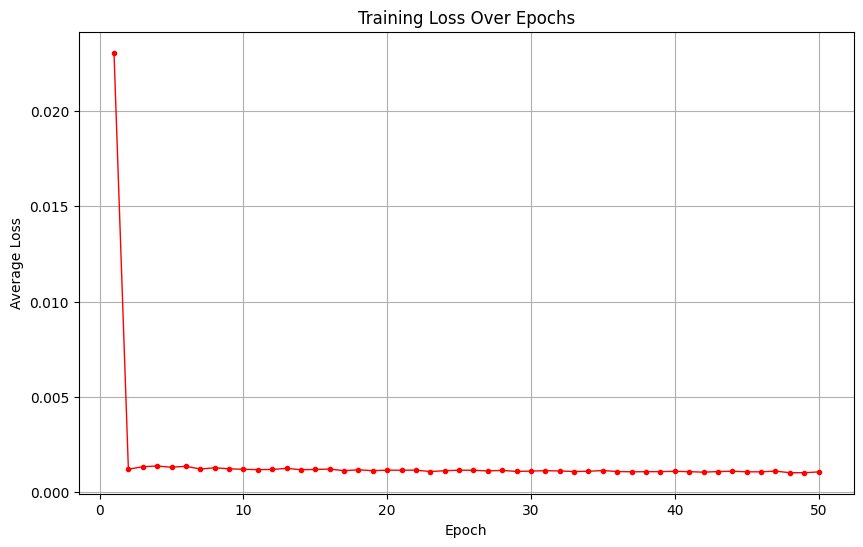

In [37]:
# Plotting training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, marker='.', linestyle='-', color='red',linewidth=1)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.savefig('./image_result/lstm_training_loss.eps', bbox_inches='tight')
plt.show()

In [38]:
# Prediction
model.eval()  # Set the model to evaluation mode

# Prepare test data
test_inputs = torch.tensor([i[0] for i in test_sequences], dtype=torch.float32).to(device)
test_labels = torch.tensor([i[1] for i in test_sequences], dtype=torch.float32).to(device)

# Generate predictions
start_time=time.time()
with torch.no_grad():
    predictions = model(test_inputs).cpu().numpy()
    true_values = test_labels.cpu().numpy()
end_time=time.time()
print("Total test time:%f" % (end_time - start_time))   # Total test time:0.092516

Total test time:0.037007


In [39]:
# Evaluate predictions
mse = mean_squared_error(true_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values, predictions)
r2 = r2_score(true_values, predictions)
evs = explained_variance_score(true_values, predictions)
mape = mean_absolute_percentage_error(true_values, predictions)


print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error: {mape}")

Mean Squared Error: 0.0017544127767905593
Root Mean Squared Error: 0.04188571125268936
Mean Absolute Error: 0.03069671243429184
R^2 Score: 0.9951258391952958
Explained Variance Score: 0.9958142638206482
Mean Absolute Percentage Error: 0.06601124256849289


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


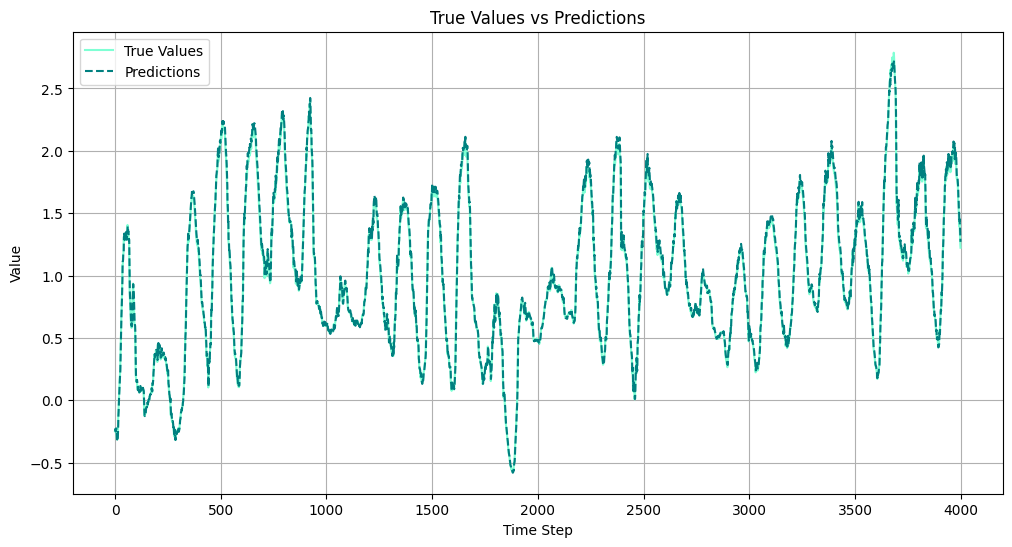

In [40]:
# Plot predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(true_values, label='True Values', color='aquamarine')
plt.plot(predictions, label='Predictions', color='teal', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('True Values vs Predictions')
plt.legend()
plt.grid(True)
plt.savefig('./image_result/LSTM_predictions_vs_true.eps', bbox_inches='tight')
plt.show()

In [41]:
# Compute FLOPs and MACs
dummy_input = torch.randn(1, timesteps, input_size).to(device)
macs, params = get_model_complexity_info(model, (timesteps, input_size), as_strings=False,
                                         print_per_layer_stat=True, verbose=True)

flops = macs * 2
print(f'FLOPs: {flops / 1e6:.7f} MFLOPs')
print(f'Number of parameters: {params}')

StandardLSTM(
  202.37 k, 100.000% Params, 204.93 KMac, 100.000% MACs, 
  (lstm1): LSTM(70.14 k, 34.661% Params, 71.42 KMac, 34.853% MACs, 7, 128, batch_first=True)
  (lstm2): LSTM(132.1 k, 65.275% Params, 133.38 KMac, 65.084% MACs, 128, 128, batch_first=True)
  (fc): Linear(129, 0.064% Params, 129.0 Mac, 0.063% MACs, in_features=128, out_features=1, bias=True)
)
FLOPs: 0.4098580 MFLOPs
Number of parameters: 202369
